In [1]:
import numpy as np
import os
import glob
import logging
import json
import sys
sys.path.append("/workspace/zecheng/modelzipper/projects")
from tqdm import tqdm
from concurrent import futures
from argparse import ArgumentParser
from change_deepsvg.svglib.svg import SVG
from change_deepsvg.svglib.geom import Bbox, Angle, Point
from change_deepsvg.difflib.tensor import SVGTensor
from modelzipper.tutils import *
import torch
from tqdm import trange
from PIL import Image

# content = auto_read_data("/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/compress_level_1_predictions.pkl")

def sanint_check_svg_tensor(x):
    """
    x: batch_size x seq_len x (7, 9)
    """
    if x.ndim == 2:
        x = x.unsqueeze(0)
    if x.size(-1) == 9:
        x[:, :, 0][x[:, :, 0] == 100] = 1
        x[:, :, 0][x[:, :, 0] == 200] = 2
    elif x.size(-1) == 7:
        # add two columns
        x_0_y_0 = torch.zeros((x.size(0), x.size(1), 2), dtype=x.dtype, device=x.device)
        x_0_y_0[:, 1:, 0] = x[:, :-1, -2]  # x_3 of the previous row
        x_0_y_0[:, 1:, 1] = x[:, :-1, -1]  # y_3 of the previous row
        x = torch.cat((x[:, :, :1], x_0_y_0, x[:, :, 1:]), dim=2)
    return x

def convert_svg(t, colored=False):
    svg = SVGTensor.from_data(t)
    svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
    svg.numericalize(n=200)
    if colored:
        import pdb; pdb.set_trace()
        svg = svg.normalize().split_paths().set_color("random")
    str_svg = svg.to_str()
    return svg, str_svg


def merge_images(
        image_path_lst, raw_image_size_w=None, raw_image_size_h=None, image_row=10, image_col=10,
    ):
    image_list = []
    for image_path in image_path_lst:
        image = Image.open(image_path)
        image_list.append(image)

    sub_image_w = raw_image_size_w if raw_image_size_w is not None else image_list[0].size[0]
    sub_image_h = raw_image_size_h if raw_image_size_h is not None else image_list[0].size[1]

    big_image_size = (sub_image_w * image_row, sub_image_h * image_col)
    big_image = Image.new('RGB', big_image_size)
    big_images = []

    for i, image in enumerate(image_list):
        i = i % (image_row * image_col)
        row = i // image_row
        col = i % image_col
        big_image.paste(image, (col * image.size[0], row * image.size[1]))
        
        if (i + 1) % (image_row * image_col) == 0:
            big_images.append(big_image)
            big_image = Image.new('RGB', big_image_size)

    return big_images

def open_image_with_gray_background(image_path, background_color=(255, 255, 255)):  
    # 打开图片并转换为RGBA模式以处理透明度  
    image = Image.open(image_path).convert('RGBA')  
      
    # 创建一个与原图大小相同的灰色背景图像  
    gray_background = Image.new('RGBA', image.size, background_color + (255,))  
      
    # 将原始图像粘贴到灰色背景图像上，透明部分将显示为灰色  
    combined_image = Image.alpha_composite(gray_background, image)  
      
    # 将合成图像转换回RGB模式，以便用于其他不支持透明度的操作  
    combined_image = combined_image.convert('RGB')  
      
    return combined_image 

def merge_images2(
    image_path_lst, raw_image_size_w=None, raw_image_size_h=None, image_row=10, image_col=10, gap_size=10, c_gap_size=10, grid_color=(0, 0, 0), scale_factor=2.0, 
):
    image_list = []
    for image_path in image_path_lst:
        image = open_image_with_gray_background(image_path)
        # image = Image.open(image_path).convert('RGB')
        image = image.resize((int(image.size[0] * scale_factor), int(image.size[1] * scale_factor)))  
        image_list.append(image) 

    
    sub_image_w = raw_image_size_w if raw_image_size_w is not None else image_list[0].size[0]
    sub_image_h = raw_image_size_h if raw_image_size_h is not None else image_list[0].size[1]

    # 计算包括网格线和空隙在内的大图尺寸
    total_gap_w = (image_col - 1) * gap_size
    total_gap_h = (image_row - 1) * c_gap_size + c_gap_size
    # print(sub_image_w, image_col, total_gap_w)
    big_image_size = (sub_image_w * image_col + total_gap_w, sub_image_h * image_row + total_gap_h)

    # 创建带有网格线和空隙的大图背景
    big_image = Image.new('RGB', big_image_size, color=grid_color)
    big_images = []

    for i, image in enumerate(image_list):
        i = i % (image_row * image_col)
        row = i // image_col
        col = i % image_col

        x_pos = col * (sub_image_w + gap_size)
        y_pos = row * (sub_image_h + c_gap_size)

        big_image.paste(image, (x_pos, y_pos))
        
        # 每满一张大图，就将其添加到big_images列表中，并创建新的大图
        if (i + 1) % (image_row * image_col) == 0 or (i + 1) == len(image_list):
            big_images.append(big_image)
            big_image = Image.new('RGB', big_image_size, color=grid_color)

    return big_images

ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.6 <<< | AOE Time🕒 2024-01-23 15:23:19


In [67]:
content[0].keys()

dict_keys(['text', 'p_svg_str', 'g_svg_str', 'r_svg_str', 'r_svg_path', 'p_svg_path', 'g_svg_path'])

## Analysis

In [66]:
anaylsis_id = [4995,14,23,33,111,300,605,573,802,927,1015,1027,1209,1721,1810,5137,1929,1940,4609,4542,5824,613,634,5511]

COMPRESS_1 = "/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/rendered_single_image"

content = auto_read_data("/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl")

prompt = [content[i] for i in anaylsis_id]

raw_image, pred_image = "{id}_r_svg.png", "{id}_g_svg.png"

raw_images = [os.path.join(COMPRESS_1, raw_image.format(id=i)) for i in anaylsis_id]
pred_images = [os.path.join(COMPRESS_1, pred_image.format(id=i)) for i in anaylsis_id]

big_map1 = merge_images2(image_path_lst=pred_images, image_row=4, image_col=6, gap_size=10, c_gap_size=50)[0]
big_map1.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/main_image.png")


begin to read data from /zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl ...


## Select Case for Comparsion

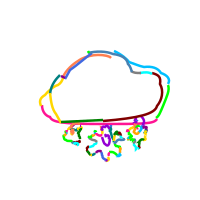

In [71]:
analysis_dir = "/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis"
id = anaylsis_id[20]
gen_svg = SVG.from_str(g_svg_str[id])
svg_tensor = gen_svg.to_tensor()
svg = SVGTensor.from_data(svg_tensor)
svg_ = SVG.from_tensor(svg.data, viewbox=Bbox(200))
file_path = os.path.join(analysis_dir, f"cloud_image_NUWASVG_{i}.png")
_ = svg_.normalize().draw_colored(fill=True, file_path=file_path)

In [ ]:
anaylsis_id = [102, 204, 226, 359, 482, 987, 1051, 1163, 1242, 1264, 1383, 1392, 1400, 1442, 1553, 1634, 1727, 1879, 1932, 2751, 2774, 3008, 3276, 3289, 3465, 3545, 3597, 4018, 4021, 4281, 4414, 5047, 5090, 5152, 5511, 5552, 5956]

root_dir = "/zecheng2/vqllama/draw_for_paper/comparison/clock"
auto_mkdir(root_dir)

content = auto_read_data("/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl")

prompt = [content[i] for i in anaylsis_id]
g_svg_str = [x['g_svg_str'] for x in content]
saved_images = []
for i in anaylsis_id: 
    gen_svg = SVG.from_str(g_svg_str[i])
    svg_tensor = gen_svg.to_tensor()
    svg = SVGTensor.from_data(svg_tensor)
    svg_ = SVG.from_tensor(svg.data, viewbox=Bbox(200))
    file_path = os.path.join(root_dir, f"image{i}.png")
    saved_images.append(file_path)
    _ = svg_.normalize().draw_colored(fill=True, file_path=file_path)

big_map1 = merge_images2(image_path_lst=saved_images, image_row=10, image_col=10, gap_size=10, c_gap_size=50)[0]
big_map1.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/quick_check.png")


begin to read data from /zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl ...


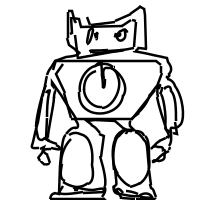

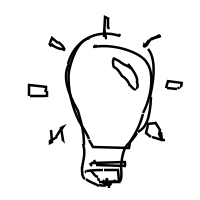

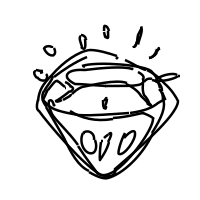

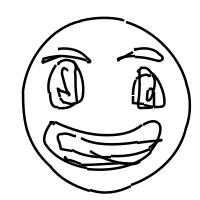

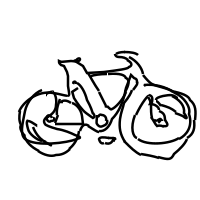

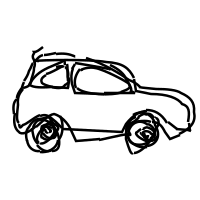

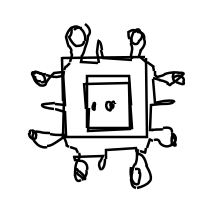

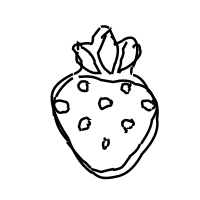

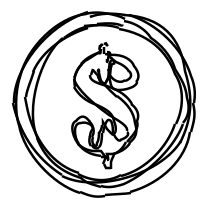

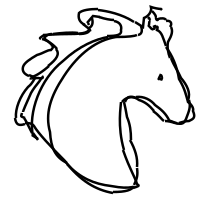

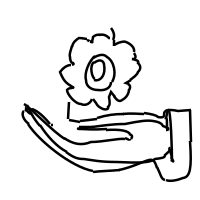

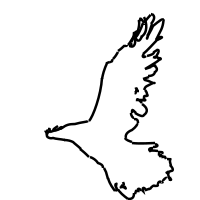

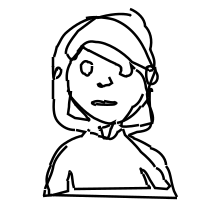

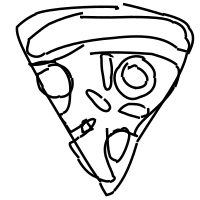

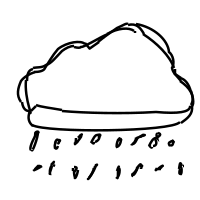

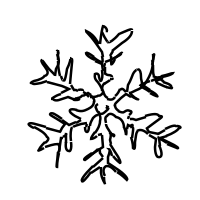

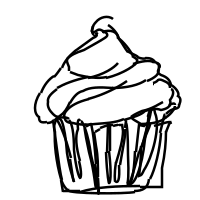

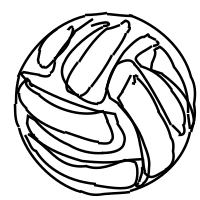

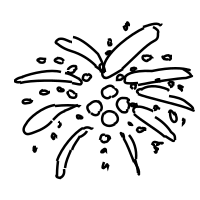

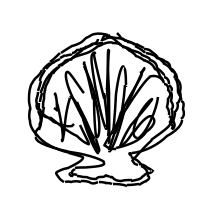

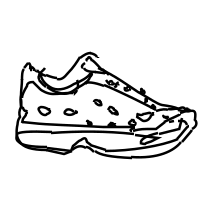

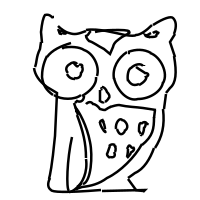

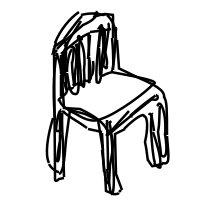

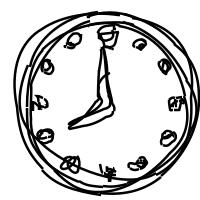

In [57]:
content = auto_read_data("/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl")

save_dir = "/zecheng2/vqllama/draw_for_paper/version_1"
image_path = []
prompt = [content[i]['text'] for i in anaylsis_id]
golden_str_path = [content[i]['g_svg_str'] for i in anaylsis_id]
for i, path in enumerate(golden_str_path):
    save_path = os.path.join(save_dir, "p_{}.png".format(i))
    image_path.append(save_path)
    svg = SVG.from_str(path)
    svg.normalize().draw(fill=True, color_firstlast=True, file_path=save_path)

big_map1 = merge_images2(image_path_lst=image_path, image_row=4, image_col=6, gap_size=10, c_gap_size=60, grid_color=(0, 0, 0))[0]
big_map1.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/main_image_2.png")


In [61]:
content[0]['text']

'blocked, block,, Shield'

In [64]:
content = auto_read_data("/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl")

all_prompt = [{content[i]['text']: i} for i in range(len(content))]

search_prompt = ["Cloud", "bulb", "Vehicle", "clock"]

for prompt in search_prompt:
    cur_search = []
    for i in range(len(content)):
        if prompt.lower() in content[i]['text'].lower():
            cur_search.append(i)
    print(prompt, cur_search)

begin to read data from /zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl ...


Cloud [9, 35, 108, 131, 176, 200, 280, 313, 343, 386, 567, 594, 703, 718, 734, 766, 1002, 1045, 1160, 1492, 1499, 1520, 1567, 1644, 1711, 1810, 1894, 1902, 1981, 1986, 2114, 2171, 2332, 2554, 3019, 3167, 3273, 3410, 3748, 3835, 3944, 4046, 4176, 4264, 4274, 4297, 4363, 4514, 4617, 4740, 4848, 4970, 5065, 5101, 5214, 5234, 5259, 5280, 5310, 5398, 5595, 5660, 5683, 5740, 5760, 5762, 5793]
bulb [14, 141, 207, 354, 580, 837, 969, 1024, 1223, 1318, 1397, 1919, 1974, 2651, 3331, 3598, 3777, 3956, 4221, 4421, 5066, 5154, 5487, 5873]
Vehicle [8, 145, 149, 152, 223, 300, 389, 453, 472, 673, 695, 724, 770, 817, 854, 907, 972, 1010, 1047, 1132, 1166, 1179, 1252, 1269, 1394, 1506, 1555, 1561, 1610, 1662, 1741, 1780, 1875, 1911, 1992, 2085, 2174, 2244, 2263, 2375, 2451, 2479, 2596, 2804, 2874, 2895, 3244, 3255, 3304, 3373, 3385, 3394, 3495, 3611, 3658, 3689, 3717, 3742, 3760, 3852, 3972, 4042, 4146, 4167, 4192, 4272, 4300, 4372, 4398, 4613, 4645, 4742, 4772, 4774, 4794, 4796, 4818, 4821, 4843, 4919

In [32]:
path = content[0]['g_svg_str']


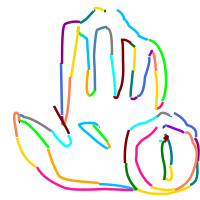

In [36]:


# svg.normalize().split_paths().set_color("random")

# svg.animate(frame_duration=0.1)

begin to read data from /zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100_visual/svg_paths.jsonl ...


0 sun, Hand, spring holiday, easter, holiday


1 creative, Light Bulb, Business, lamp, shiny, Idea


2 Diamond, high end, Jewelry, fashion, jewel


3 emotion, joy, Smiley, Smile, glad, emoticon


4 Cycling, Sport, biking, city bike, Bicycle, Bike


5 eco, Car, Vehicle, drive, transport


6 Microchip, processor, automation, Artificial Intelligence, Robotics, Microcontroller


7 fruitds, Fruit, Fresh, Food, sweet, Strawberry, images


8 Money, coin, cash, currency, dollar, Wealth


9 Horse, strong, Animal, horses, HORSE KNIGHT, ride


10 Safety, SEO, optimization, setting, Productivity


11 Crow, Animal, Bird, fly, wing


12 people, avatar, character, Short Hair Woman, Woman


13 Pizza, fast, Slice, Cheese, Food


14 Rain, sky, Cloud, weather, raincloud, outdoors


15 frozen, Snow, Snowflake, weather, Winter, Cold


16 Quick bread, Corn muffin, baked goods, Muffins, cup cake, Bread, Bran muffin, Bite size, baked, Cake, Cup, Food, Cupcake, Dessert, Frosting


17 Ball, Sport, Volleyball, G

In [35]:
content[0].keys()

dict_keys(['text', 'p_svg_str', 'g_svg_str', 'r_svg_str', 'r_svg_path', 'p_svg_path', 'g_svg_path'])

## Merge Big Figures 

In [29]:
already_used_ids = [46, 48, 51, 62, 160, 167, 177, 199, 149, 125, 127, 228, 231, 237, 390, 393, 389, 460, 578, 853, 866, 1193, 1188, 1151, 1200, 1281, 1433, 1530, 1627, 1641, 1642, 1692, 1831, 1839]

[1284, 979, 661, 117, 490, 486, 378, 147, 1407, 590, 52, 526, 1740, 610, 879, 1594, 972, 736, 960, 1293, 0, 836, 447, 1081]


In [21]:
ID = [46, 48, 51, 62, 160, 167, 177, 199, 149, 125, 127, 228, 231, 237, 390, 389, 460, 578, 866, 1193, 1188, 1151, 1200, 1381, 1433, 1530, 1627, 1641, 1692, 1831] # 1642, 1530, 853

sampled_ID = random.sample(ID, 8)

SINGLE_IMAGE_DIR = "/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/epoch_8100/rendered_single_image"
p_suffix, g_suffix, r_suffix = "{id}_p_svg.png", "{id}_g_svg.png", "{id}_r_svg.png"

print(sampled_ID)

p_i = [os.path.join(SINGLE_IMAGE_DIR, p_suffix.format(id=i)) for i in sampled_ID]
g_i = [os.path.join(SINGLE_IMAGE_DIR, g_suffix.format(id=i)) for i in sampled_ID]
r_i = [os.path.join(SINGLE_IMAGE_DIR, r_suffix.format(id=i)) for i in sampled_ID]

merge_lst = p_i + g_i + r_i

big_map = merge_images2(image_path_lst=merge_lst, image_row=3, image_col=8, gap_size=5)[0]

big_map.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/EDM_SAMPLE.pdf")

[127, 46, 199, 1530, 460, 1200, 1627, 237]


In [27]:
merge_sample_lst3 = merge_sample_lst1 + merge_sample_lst2

big_map1 = merge_images2(image_path_lst=merge_sample_lst3, image_row=6, image_col=12, gap_size=5)[0]
# big_map2 = merge_images2(image_path_lst=merge_sample_lst2, image_row=3, image_col=12, gap_size=5)[0]

big_map1.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/recon_c1_sample_3.pdf")
# big_map2.save("/workspace/zecheng/modelzipper/projects/custom_llama/notebook/recon_c1_sample_2.pdf")

## Analysis single image

In [9]:
p_predict = content['p_predict']
raw_predict = content['raw_predict']
golden = content['golden']

sample_p_0 = p_predict[0]
sample_r_0 = raw_predict[0]
sample_g_0 = golden[0] 

sample_p_0 = sanint_check_svg_tensor(sample_p_0).squeeze(0)
sample_r_0 = sanint_check_svg_tensor(sample_r_0).squeeze(0)
sample_g_0 = sanint_check_svg_tensor(sample_g_0).squeeze(0)

print(sample_p_0.shape)
print(sample_r_0.shape)
print(sample_g_0.shape)

torch.Size([278, 9])
torch.Size([200, 9])
torch.Size([200, 9])


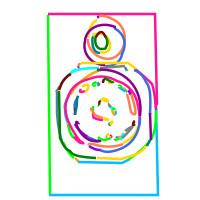

In [10]:

svg = SVGTensor.from_data(sample_p_0)
svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
svg.numericalize(n=200)

# svg.normalize().split_paths().set_color("random")
svg.draw_colored(fill=True, color_firstlast=True)
# svg.animate(frame_duration=0.1)

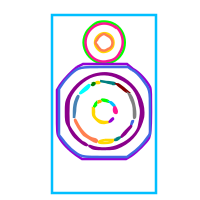

In [13]:

svg = SVGTensor.from_data(sample_g_0)
svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
svg.numericalize(n=200)

# svg.normalize().split_paths().set_color("random")
svg.draw_colored(fill=True, color_firstlast=True)
# svg.animate(frame_duration=0.1)

In [19]:
tmp = auto_read_data("/zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/snap_0_results.pkl")

begin to read data from /zecheng2/vqllama/test_vq_seq2seq/test_flat_t5/snap_0_results.pkl ...


In [18]:
len(tmp)

{'keywords': ['speaker'],
 'mesh_data': tensor([[  0.,   0.,   0.,  ...,   0.,   4., 104.],
         [  1.,   4., 104.,  ...,   0.,   4., 199.],
         [  1.,   4., 199.,  ...,   0., 199., 199.],
         ...,
         [  2., 113., 140.,  ..., 140., 113., 140.],
         [  2., 113., 140.,  ..., 140., 105., 140.],
         [  1., 105., 140.,  ...,   0., 105., 140.]])}

In [16]:
def remove_padding(x, padding_mask):
    """
    x: (batch_size x) seq_len num_bins
    padding: seq_len x num_bins

    if batch, return List[Tensor]
    if tensor, return Tensor
    """
    if x.ndim == 2:  # seq_len x num_bins
        return x[:padding_mask.sum(), :]
    elif x.ndim == 3:  # batch_size x seq_len x num_bins
        res = []
        for i in range(x.size(0)):
            res.append(x[i, :padding_mask[i].sum(), :])
        return res

def postprocess(x, padding_mask=None, path_interpolation=True):
    """
    postprocess the generated results

    x: batch_size x seq_len x 9
    padding_mask: batch_size x seq_len
    path_interpolation: whether to interpolate the path
    """
    dtype = x.dtype
    if x.ndim == 2:
        x = x.unsqueeze(0)
    if padding_mask.ndim == 1:
        padding_mask = padding_mask.unsqueeze(0)

    if path_interpolation:  
        # conduct path interpolation
        # return List[Tensor]
        batch_size = x.size(0)
        x = remove_padding(x, padding_mask)  # remove the padding
        full_x = []
        for i in range(batch_size):
            current_path = []
            last_x3, last_y3 = None, None
            seq_len = x[i].size(0)
            for j in range(seq_len):
                row = x[i][j]
                cmd = 100 * torch.round(row[0] / 100).item()
                cmd = 1 if cmd == 100 else 2 if cmd == 200 else 0
                x0, y0, x1, y1, x2, y2, x3, y3 = map(lambda coord: min(max(coord, 0), 200), row[1:].tolist())
                if last_x3 is not None and (last_x3 != x0 or last_y3 != y0):
                    # if the current row's start point is not the same as the previous row's end point
                    current_path.append([0, last_x3, last_y3, 0, 0, 0, 0, x0, y0])
                if cmd in [0, 100]:
                    # if the current row is M or L, set control point to 0
                    x1, y1, x2, y2 = 0, 0, 0, 0
                current_path.append([cmd, x0, y0, x1, y1, x2, y2, x3, y3])
                last_x3, last_y3 = x3, y3  # update the last end point
            full_x.append(torch.tensor(current_path, dtype=dtype))
    
    else:  # no path interpolation
        if x.size(-1) == 9:
            # first remove the 1, 2 columns
            m_x = torch.cat((x[:, :, :1], x[:, :, 3:]), dim=2)
        else:
            m_x = x
        # find the right command value
        m_x[:, :, 0] = torch.round(m_x[:, :, 0] / 100) * 100
        # clip all the value to max bins 
        m_x = torch.clamp(m_x, 0, 200)
        # process the M and L path                                                              
        m_x[:, :, 1:5][m_x[:, :, 0] != 200] = 0
        # add to extra column to satisfy the 9 columns
        x_0_y_0 = torch.zeros((m_x.size(0), m_x.size(1), 2), dtype=m_x.dtype, device=m_x.device)
        x_0_y_0[:, 1:, 0] = m_x[:, :-1, -2]  # x_3 of the previous row
        x_0_y_0[:, 1:, 1] = m_x[:, :-1, -1]  # y_3 of the previous row
        full_x = torch.cat((m_x[:, :, :1], x_0_y_0, m_x[:, :, 1:]), dim=2)
        # replace the command value to 0, 1, 2
        full_x[:, :, 0][full_x[:, :, 0] == 100] = 1
        full_x[:, :, 0][full_x[:, :, 0] == 200] = 2
        # remove the padding
        full_x = remove_padding(full_x, padding_mask)

    return full_x

In [15]:

svg = SVGTensor.from_data(sample_r_0)
svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
svg.numericalize(n=200)

# svg.normalize().split_paths().set_color("random")
svg.draw_colored(fill=True, color_firstlast=True)
svg.animate(frame_duration=0.1)

ValueError: 'SOS' is not a valid SVGCmdEnum